# 智能计算系统第三次作业
> 朱浩泽 1911530 计算机科学与技术

## 问题一
请调研了解常用的图像数据预处理和数据增强方法。实现一个函数，从 ImageN-et2012_val 数据集中选择一张图片文件并读入数据，调整为（256, 256, 3）大小的图片，然后居中裁剪为(224, 224, 3）大小的图片；再实现一个函数，读入数据后居中裁剪为 (0.875 x width, 0.875* height,3）大小的图片，再调整为 (224, 224, 3）大小的图片
### 图像预处理和数据增强方法

### 图像预处理实战
- 首先我们定义一个函数，在数据集中随机选择一张图片

In [61]:
import tensorflow as tf
import pathlib
import random
import matplotlib.pyplot as plt


def chosen_img(path):
    data_root = pathlib.Path(path)
    img_list = []
    for item in data_root.iterdir():
        img_list.append(str(item))
    chosen = img_list[random.randint(0, len(img_list))]
    return chosen

- 我们将选中的图片以tensor的形式进行保存

In [62]:
def read_img(chosen):
    img_raw = tf.io.read_file(chosen)
    img_tensor = tf.image.decode_image(img_raw)
    return img_tensor

- 定义函数对张量进行处理，调整为（256, 256, 3）大小的图片

In [63]:
def reshape(img_tensor):
    img_reshape = tf.image.resize(img_tensor, [256, 256])
    if img_tensor[0][0][0] > 1:
        img_reshape /= 255
    return img_reshape

- 定义函数将tensor居中裁剪为(224, 224, 3）大小的图片

In [64]:
def cut(img_tensor):
    cut = tf.image.resize_with_crop_or_pad(img_tensor, 224, 224)
    if cut[0][0][0] > 1:
        cut /= 255
    return cut

- 读入数据后进行处理

In [65]:
path = "n04579432"
img_path = chosen_img(path)
img_tensor1 = read_img(img_path)
a = reshape(img_tensor1)
a = cut(a)
img_tensor2 = read_img(img_path)
b = cut(img_tensor2)
b = reshape(b)

- 先调整后裁剪的图片如下

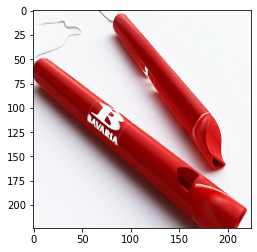

In [66]:
plt.imshow(a)

- 先裁剪后调整的图片如下

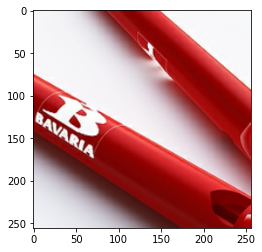

In [67]:
plt.imshow(b)

## 问题二
查看 TensorFlow 源码，在core/ops 中，查找涉及conv 算子的代码，请简述算子注册流程。

## 问题三
查看 TensorFlow 源码，在core/kernel 中，查找涉及conv算子的代码，请简述卷积的具体实现。

## 问题四
现在常见的几种机器学习框架均支持混合精度 (Mixed Precision） 训练方法，该方法采用半精度浮点做正向传播计算，使用单精度浮点做反向传播计算，在训练时需要同时存储半精度和单精度两份数据。调研了解Mixed Precision的具体实现方法，并借鉴此思想，简述如何实现稀疏卷积神经网络模型的训练。注：稀疏卷积神经网络模型一般指卷积层和全连接层的权重中有很多0元素的模型。稀疏模型采用稠密矩阵或者稀疏矩阵方法存储均可。